In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on May 15 2025

@author: pablo
"""

from roboticstoolbox import RevoluteMDH, DHRobot
from spatialmath import SE3
import roboticstoolbox as rtb
import numpy as np




# Estudio de la dinámica del sistema

In [ ]:
# Datos del doble péndulo
L = 0.2  # metros
w = 0.02 # metros
m = 1.5 # Kg
Jm = 0.0001
B = 0.1
N = 10
rg = np.array([L/2,0,0]) # El centro de masa está en la mitad de la barra
Ig = np.array([[1/12*m*(w**2+w**2),0,0],[0,1/12*m*(w**2+L**2),0],[0,0,1/12*m*(w**2+L**2)]]) # Matriz de inercia


        # Crear la estructura del robot
dp = DHRobot([
        # Modelo por DH proximal (o modificado)
        RevoluteMDH(a=0, alpha=0, d=0, m=m, r=rg, I=Ig, Jm=Jm, B=B, G=N),
        RevoluteMDH(a=L, alpha=0, d=0, m=m, r=rg, I=Ig,  Jm=Jm, B=B, G=N)
        ], 
        name='dp', 
        gravity = np.array([0, -9.8,0]),
        tool = SE3(L, 0, 0)
        )   
        
print(dp)
print(dp.dynamics())

# Estudiamos la dinámica para q_din
q_din = np.array([0, np.pi/2])
qp_din = np.array([0, 0])
print("POSE en la que estudiamos la dinámica para el control\n",dp.fkine(q_din))

# Matriz de inercia completa Mu=M+Jm*N^2
Mu = dp.inertia(q_din)
#tf = dp.jointdynamics(qp_din, q_din)
print(Mu)




DHRobot: dp, 2 joints (RR), dynamics, modified DH parameters
┌──────┬──────┬─────┬────┐
│ aⱼ₋₁ │ ⍺ⱼ₋₁ │ θⱼ  │ dⱼ │
├──────┼──────┼─────┼────┤
│    0 │ 0.0° │  q1 │  0 │
│  0.2 │ 0.0° │  q2 │  0 │
└──────┴──────┴─────┴────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0.2, 0, 0; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌───────┬──────┬──────────────┬─────────────────────────────────────────┬─────────┬──────┬────────┬─────┐
│   j   │  m   │      r       │                    I                    │   Jm    │  B   │   Tc   │  G  │
├───────┼──────┼──────────────┼─────────────────────────────────────────┼─────────┼──────┼────────┼─────┤
│ link1 │  1.5 │  0.1,  0,  0 │  0.0001,  0.00505,  0.00505,  0,  0,  0 │  0.0001 │  0.1 │  0,  0 │  10 │
│ link2 │  1.5 │  0.1,  0,  0 │  0.0001,  0.00505,  0.00505,  0,  0,  0 │  0.0001 │  0.1 │  0,  0 │  10 │
└───────┴──────┴──────────────┴─────────────────────────────────────────┴─────────┴──────┴────────┴─────

# Linealización de la planta

Función de transferencia del eje 1 G(s): 
        1
-----------------
0.1101 s^2 + 10 s



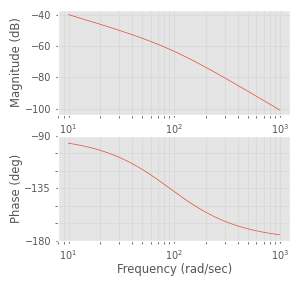

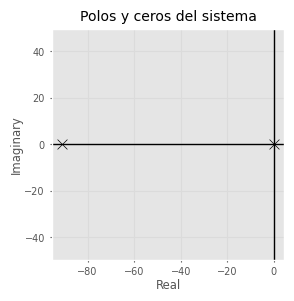


Polos del sistema: [-90.82652134+0.j   0.        +0.j]
Ceros del sistema: []
Función de transferencia del eje 2 G(s): 
        1
------------------
0.03005 s^2 + 10 s



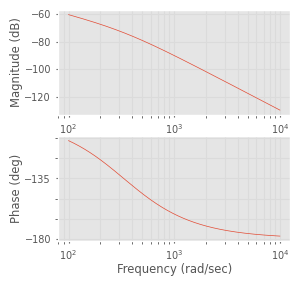

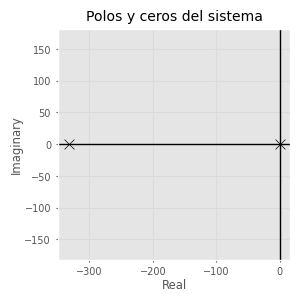


Polos del sistema: [-332.77870216+0.j    0.        +0.j]
Ceros del sistema: []


In [29]:
import control as ctl
import matplotlib.pyplot as plt

# Linealización del doble péndulo
# Coeficientes del numerador y denominador

G=[None] * 2
poles_G = []
zeros_G = []
for idx_eje in [0,1]:
    numerador = [1]    
    denominador = [Mu[idx_eje,idx_eje], B*N**2,0 ]

    # Crear el sistema de transferencia
    G[idx_eje] = ctl.TransferFunction(numerador, denominador) 
    G[idx_eje].name = f"G_{idx_eje+1}"

    # Mostrar la función de transferencia
    print(f"Función de transferencia del eje {idx_eje+1} G(s):",G[idx_eje])

    # Diagrama de Bode
    plt.figure().set_size_inches(3,3)
    mag, phase, omega = ctl.bode(G[idx_eje], dB=True)
    plt.show()

    # Gráfico de polos y ceros
    plt.figure().set_size_inches(3,3)
    ctl.pzmap(G[idx_eje], title="Polos y ceros del sistema")
    plt.show()

    # Polos y ceros
    poles_G.append(ctl.pole(G[idx_eje]))
    zeros_G.append(ctl.zero(G[idx_eje]))

    print("\nPolos del sistema:", poles_G[idx_eje])
    print("Ceros del sistema:", zeros_G[idx_eje])


# Diseño y evaluación de la ganancias del controlador

Kp:  400 Ti:  0.6 Td:  0.0030050000000000007


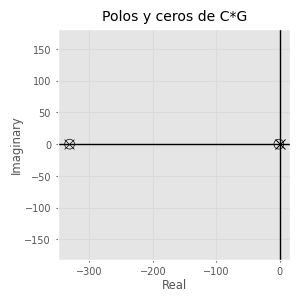

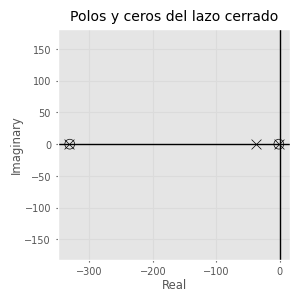

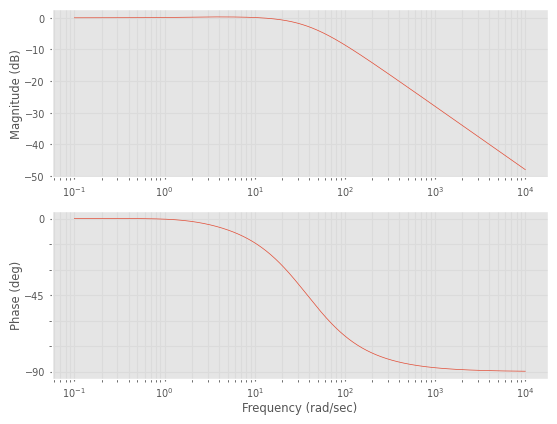

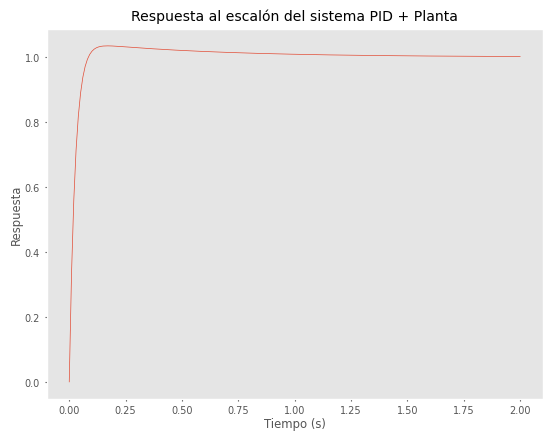

Sobrepico: 3.27 %
Tiempo de pico: 0.17 s
Frecuencia de corte: 6.60 Hz
Ajuste del controlador del eje  2
Kp: 400.00  Ki:666.67  Kd:1.20


In [ ]:
ejes = [0]
Tfin = 2

# Ajuste por ZN
flag_ZN = False

if flag_ZN:
    Ku1 = 280
    Tu1 = (14.7-13.4)/10    
    Ku2 = 1100
    Tu2 = (7.17-6.95)/10
    K = [{'kp': 0.6*Ku1, 'Ti': 0.5*Tu1, 'Td': 0.125*Tu1},
        {'kp': 0.6*Ku2, 'Ti': 0.5*Tu2, 'Td': 0.125*Tu2}]
else:
    K = [{'kp': 400, 'Ti': 0.8, 'Td': -1/poles_G[0][0].real},
        {'kp': 400, 'Ti': 0.6, 'Td': -1/poles_G[1][0].real}]

Gcl = [None] * len(G)  # Inicializar la lista de sistemas en lazo cerrado
for idx_eje in ejes:
    print("Kp: ", K[idx_eje]['kp'], "Ti: ", K[idx_eje]['Ti'], "Td: ", K[idx_eje]['Td'])
    PID = ctl.TransferFunction(K[idx_eje]['kp'] * np.array([K[idx_eje]['Td'], 1, 1/K[idx_eje]['Ti']]), [1, 0])

    # 2. Sistema en lazo abierto Gol (PID * Planta)
    Gol = PID * G[idx_eje]  # Sistema en lazo abierto
    Gcl[idx_eje] = ctl.feedback(Gol, 1)  # Sistema en lazo cerrado
    Gcl[idx_eje].name = "eje " + str(idx_eje+1)

    plt.figure().set_size_inches(3,3)
    ctl.pzmap(Gol, title="Polos y ceros de C*G") 
    plt.show()

    plt.figure().set_size_inches(3,3)
    ctl.pzmap(Gcl[idx_eje], title="Polos y ceros del lazo cerrado")
    plt.show()

    # 3. Diagrama de Bode
    mag, phase, omega = ctl.bode(Gcl[idx_eje], dB=True)

    # 4. Respuesta al escalón
    t = np.linspace(0, Tfin, 200)
    t, y = ctl.step_response(Gcl[idx_eje], T=t)
    plt.figure()
    plt.plot(t, y)
    plt.title("Respuesta al escalón del sistema PID + Planta")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Respuesta")
    plt.grid()
    plt.show()

    # 5. Calculo de parametros de rendimiento

    # Sobrepico en porcentaje
    Mp = (np.max(y) - y[-1]) / y[-1] * 100
    print(f"Sobrepico: {Mp:.2f} %")

    # Tiempo de pico
    t_peak = t[np.argmax(y)]
    print(f"Tiempo de pico: {t_peak:.2f} s")

    # La frecuencia de corte es la frecuencia a la que la magnitud de la respuesta es 1/sqrt(2) veces el valor máximo
    cutoff_freq = omega[np.where(mag < 1/np.sqrt(2))[0][0]]/2/np.pi
    print(f"Frecuencia de corte: {cutoff_freq:.2f} Hz")

    # Calculo de ganancias
    print("Ajuste del controlador del eje ", idx_eje+1)
    kp = K[idx_eje]['kp']
    ki = kp/K[idx_eje]['Ti']
    kd = kp*K[idx_eje]['Td']
    print(f"Kp: {kp:.2f}  Ki:{ki:.2f}  Kd:{kd:.2f}")

# Optimización

In [ ]:
# Función para simular el sistema
def simulate_pid(Kp, Kd, Ki, G, T_span=0.5, sys_name="Sistema de lazo cerrado" ,showbode = False):
  C = ctl.TransferFunction([Kd, Kp, Ki], [1, 0])  # PID: Kd*s + Kp + Ki/s
  # Sistema en lazo cerrado
  sys_cl = ctl.feedback(C * G)
  sys_cl.name = sys_name
  if showbode:
    ctl.bode_plot(sys_cl)
    plt.show()
  # Respuesta al escalón
  t, y = ctl.step_response(sys_cl,T=np.linspace(0, T_span, 150))
  return t,y


# Función para calcular métricas de rendimiento
def performance_metrics(t, y):
    Mp = np.max(y) - 1    # Sobrepico
    Tr = t[np.where(y >= 0.9)[0][0]] if np.any(y >= 0.9) else 10  # Tiempo de respuesta
    ess = np.abs(1 - y[-1])  # Error en estado estacionario
    return Mp, Tr, ess

# Función para calcular el funcional J
def cost_function(Mp, Tr, ess):
    return w1 * (Mp - Mp_ref)**2 + w2 * (Tr - Tr_ref)**2 + w3 * (ess - ess_ref)**2



In [49]:
# Inicialización 
idx_eje = 0
Kp, Kd, Ki = K[idx_eje]['kp'], K[idx_eje]['kp'] * K[idx_eje]['Td'] , K[idx_eje]['kp'] / K[idx_eje]['Ti']

Epoch 200: J = 0.0025, Kp = 400.072, Kd = 4.558, Ki = 499.975
Epoch 400: J = 0.0025, Kp = 400.079, Kd = 4.572, Ki = 499.973
Epoch 600: J = 0.0025, Kp = 400.085, Kd = 4.586, Ki = 499.971
Epoch 800: J = 0.0025, Kp = 400.092, Kd = 4.600, Ki = 499.968
Epoch 1000: J = 0.0025, Kp = 400.098, Kd = 4.613, Ki = 499.966
Epoch 1200: J = 0.0025, Kp = 400.105, Kd = 4.626, Ki = 499.964
Epoch 1400: J = 0.0025, Kp = 400.111, Kd = 4.639, Ki = 499.961
Epoch 1600: J = 0.0025, Kp = 400.118, Kd = 4.652, Ki = 499.959
Epoch 1800: J = 0.0025, Kp = 400.124, Kd = 4.665, Ki = 499.957
Epoch 2000: J = 0.0025, Kp = 400.131, Kd = 4.677, Ki = 499.955


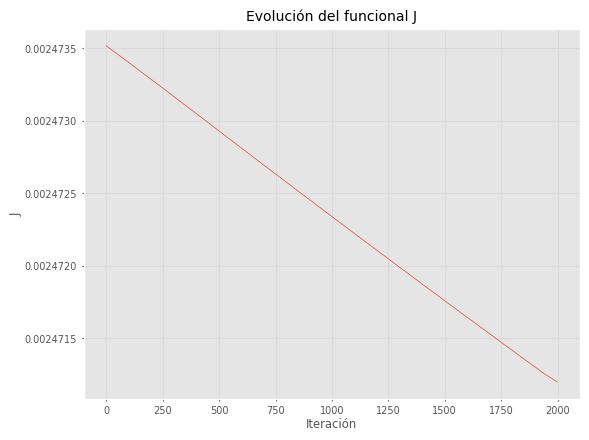

In [52]:
# Parámetros deseados
Mp_ref = 0.01    # Sobrepico deseado
Tr_ref = 0.1    # Tiempo de respuesta deseado
ess_ref = 0.0   # Error en estado estacionario deseado

# Pesos del funcional
w1, w2, w3 = 1.0, 1.0, 1.0

# Inicialización de ganancias PID en un lugar cercano a donde lo quiero
# La optimización es en un entorno muy acotado
#Kp, Kd, Ki = 100, 6, 100
#Kp, Kd, Ki = 300, 3, 800

eta = 5   # Tasa de aprendizaje
N = 2000
# Iteración de optimización
J_acum = []
Kp0, Kd0, Ki0 = Kp, Kd, Ki 
for epoch in range(N):
    # Simular el sistema con las ganancias actuales
    t, y = simulate_pid(Kp, Kd, Ki,G[idx_eje])
    # Calcular las métricas de rendimiento
    Mp, Tr, ess = performance_metrics(t, y)
    J = cost_function(Mp, Tr, ess)

    # Calcular el gradiente (estimación numérica)
    dJ_dKp = (cost_function(*performance_metrics(*simulate_pid(Kp + 0.1, Kd, Ki,G[idx_eje]))) - J) / 0.1
    dJ_dKd = (cost_function(*performance_metrics(*simulate_pid(Kp, Kd + 0.1, Ki,G[idx_eje]))) - J) / 0.1
    dJ_dKi = (cost_function(*performance_metrics(*simulate_pid(Kp, Kd, Ki + 0.1,G[idx_eje]))) - J) / 0.1

    #print(dJ_dKp,dJ_dKd,dJ_dKi)
    # Actualizar las ganancias
    Kp -= eta * dJ_dKp
    Kd -= eta * dJ_dKd
    Ki -= eta * dJ_dKi

    # Mostrar progreso
    if (epoch + 1) % 200 == 0:
      print(f"Epoch {epoch+1}: J = {J:.4f}, Kp = {Kp:.3f}, Kd = {Kd:.3f}, Ki = {Ki:.3f}")

    J_acum.append(J)

# Resultado final
plt.plot(J_acum)
plt.title("Evolución del funcional J")
plt.xlabel("Iteración")
plt.ylabel("J")
plt.show()


Ganancias iniciales:
Kp = 400.065, Kd = 4.544, Ki = 499.977

Ganancias optimizadas:
Kp = 400.131, Kd = 4.677, Ki = 499.955


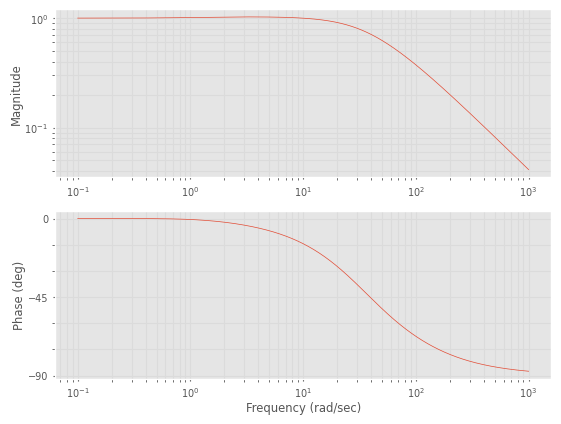

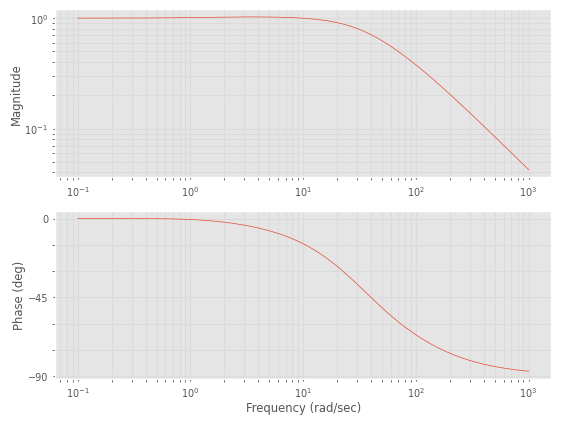

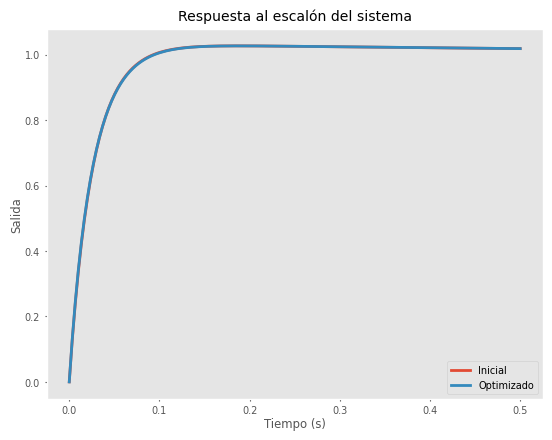

In [53]:
print("\nGanancias iniciales:")
print(f"Kp = {Kp0:.3f}, Kd = {Kd0:.3f}, Ki = {Ki0:.3f}")
print("\nGanancias optimizadas:")
print(f"Kp = {Kp:.3f}, Kd = {Kd:.3f}, Ki = {Ki:.3f}")

t0, y0 = simulate_pid(Kp0, Kd0, Ki0, G[idx_eje],sys_name='Inicial',showbode = True)
t, y = simulate_pid(Kp, Kd, Ki, G[idx_eje],sys_name='Optimizado',showbode = True)

plt.plot(t0,y0,t,y,linewidth=2)
plt.title("Respuesta al escalón del sistema")
plt.xlabel("Tiempo (s)")
plt.ylabel("Salida")
plt.legend(["Inicial","Optimizado"])
plt.grid()
plt.show()